In this assignment, we analyze the MNIST handwritten digits dataset using <br>
neural networks. The dataset consists of greyscale images of hand written digits <br>
0, 1, . . . , 9 that have been normalized to 28 × 28 bitmap images. Each image is <br>
accompanied by the correct label. We will construct a classifier that classifies <br>
the images to their correct labels.

## Problem 1
Set up PyTorch in your Anaconda environment. The following invocation should <br>
install the CPU only version: <br>
```bash
conda install -c pytorch pytorch torchvision cpuonly <br>
```
Load the dataset (both training and test set) using the torchvision.datasets <br>
module. Note that the you probably want to use the transform option to <br>
convert the images into Tensors. By default, the images come as PIL1 images. <br>
Use matplotlib to plot some images in greyscale, and include at least one <br>
from each set in your report. Verify that the images have the correct dimensions <br>
(28 × 28) and scale for values (values should be normalized to be in range [0, 1]).

torch.Size([10000, 28, 28])
torch.Size([60000, 28, 28])
Max element size in first train sample 1.0
Min element size in first train sample 0.0


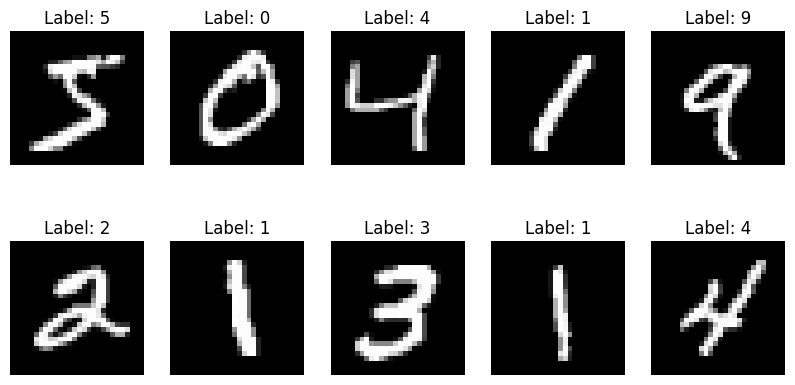

In [26]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import Tensor

transformer = transforms.Compose([
    transforms.ToTensor(),
])

train_set = MNIST(root='./data', download=True, transform=transformer, train=True)
test_set = MNIST(root='./data', download=True, transform=transformer, train=False)

print(test_set.data.shape) # Test data is 10000 examples of 28x28
print(train_set.data.shape) # Train data is 60000 examples of 28x28

image, label = train_set[0]
# Print the first image in the training and test sets to show the normalisation
print(f'Max element size in first train sample {torch.max(image)}')
print(f'Min element size in first train sample {torch.min(image)}')

# Show the first 10 training image as a nparray mapped to a grayscale image
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image: Tensor = train_set[i][0]
    label = train_set[i][1]
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

## Problem 2
Construct a fully-connected feedforward network with one hidden layer. Use <br>
the ReLU as the activation function. Train the network for at least 10 epochs <br>
using stochastic gradient descent (torch.optim.SGD) for optimization and cross <br>
entropy loss (torch.nn.CrossEntropyLoss) for loss function. Report the vali- <br>
dation accuracy of your network (with respect to the test set) after each epoch. <br>
Report all relevant parameters you chose.

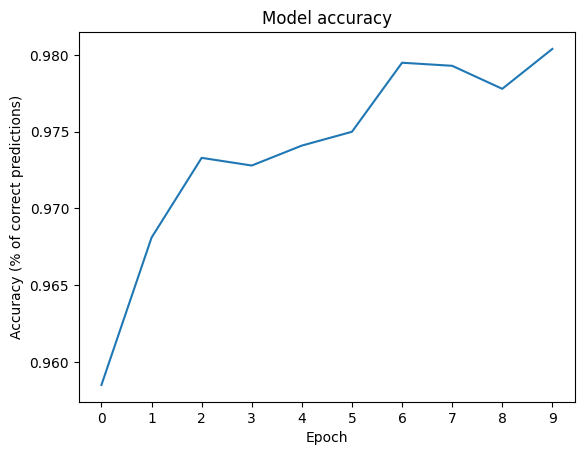

In [27]:
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data.dataloader import DataLoader

# Hyperparameters
N_EPOCHS = 10
BATCHSIZE = 10
LR = 0.1
INPUT_SIZE = 28*28
HIDDEN_SIZE = 128
OUTPUT_SIZE = 10

# For our model we went for a 10 element output tensor where each element correspond to a certain image being a number
# No acitvation function in ouput layer as this was not mentioned in the task, from what we read this is also not
# necessary as the CrossEntropyLoss function will apply the softmax function to the output of the model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE) 
)

# Loss function to calculate predictions vs label distance, 
# and optimizer (Stochastic Gradient Descent) to modify model weights.
loss_function = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LR)

# Divide data into batches, shuffe only the training data.
# There is no need to shuffle test data since its not for training
# and does not affect the weights of the model.
train_loader = DataLoader(train_set, batch_size=BATCHSIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCHSIZE, shuffle=False)

# Training the model using batches, we got faster results when training the 
# model on the whole data set at once. Albeit that is more memory intensive when using bigger datasets.
# We never apply softmax to the output of the model as the CrossEntropyLoss function will do this for us
# in training. In the evaluation phase this isnt necessary either since the argmax function will still return the
# correct class, or "highest probability" if you will.

accuracies = []

for i in range(N_EPOCHS):

    # Training loop

    model.train() # set model to training mode, im guessing this enables some things internally in PyTorch
    for batch in train_loader:
        Xs_train, ys_train = batch
        optimizer.zero_grad() # zero the gradients
        ys_pred = model(Xs_train)
        loss: Tensor = loss_function(ys_pred, ys_train)
        loss.backward() # backward pass
        optimizer.step() # update weights

    correct = 0
    total = 0

    # Evaluation loop

    model.eval() # set model to evaluation mode, im guessing this disables some things internally in PyTorch
    with torch.no_grad(): # no need to track gradients during evaluation
        for batch in test_loader:
            Xs_test: Tensor = batch[0]
            ys_test: Tensor = batch[1]
            output: Tensor = model(Xs_test)
            predicted = torch.argmax(output, 1)
            total += ys_test.size(0)
            # sum up all elements in the tensor that are equal
            # use .item() to get the value as a python number as 
            # result is a tensor with one element
            correct += (predicted == ys_test).sum().item() 
            accuracy = correct / total
            
    accuracies.append(accuracy)

plt.plot(accuracies)
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.xticks(range(N_EPOCHS))
plt.ylabel(r'Accuracy (% of correct predictions)')
plt.show()
